## <b>Solving axisymmetric magnetostatic problem via Phycisc Informed Neural Networks (PINNs)<b>

This notebook gives an example of how to solve axisymmetric magnetostatic problem via Phycisc Informed Neural Networks (PINN) and TensorFlow (TF) and `tf.GradientTape`. 

### <b>Brief description of the problem<b>
Let consider a cilyndrical coordinate system $(r,z,\phi)$, and a limited computational domain $\Omega$ in the region $(r,z)\in(0,+\infty)\times(-\infty,+\infty)$. Let $\partial\Omega$ be the boundary of the computational domain. Inside $\Omega$, we define two additional regions: the source region $\Omega_s$, where a souce current $J_{\phi}$ is flowing, and the vacuum region $\Omega_v$ without sources (i.e. $J_{\phi} = 0$).

The axisymmetric magnetostatic problem is described by the following equations:
\begin{cases}
    \nabla \cdot \biggl( \frac{1}{r} \nabla \psi \biggr)  = -\mu_0J_\phi \\
    \psi|_{\partial\Omega} = \psi_{bc}
\end{cases}
where $\psi = rA_{\phi}$, being $A_{\phi}$ the $\phi$ component of the magnetic vector potential $\vec{A}$, $J_{\phi} \neq 0$ only in $\Omega_s$,  and $\psi_{bc}$ the boundary conditions.

### <b>Implementation<b>
Import the required libraries.

In [46]:
import numpy as np
from sklearn import preprocessing 
import tensorflow as tf
from matplotlib import pyplot as plt
plt.close('all')

import scipy.io as io

import pandas as pd

import seaborn as sns
sns.set_style("darkgrid")

from datetime import datetime

Load some reference data, such as the boundary conditions and the *collocation poits*, i.e., the points where we are going to enforce that the derivatives of the network will satisfy the magnetostatic equation.

In [47]:
#Coils' geometry
theta = np.linspace(0,2*np.pi,50)
RC1 = .3+.1
RC2 = .7+.1
rho_C1 = .1
rho_C2 = .1

coil1 = np.column_stack((RC1+rho_C1*np.cos(theta), rho_C1*np.sin(theta)));
coil2 = np.column_stack((RC2+rho_C2*np.cos(theta), rho_C2*np.sin(theta)));


# Load a .mat file with the reference data
folder = 'C:\\Users\\matte\\Dropbox\\PhD\\RESEARCH_ACTIVITY\\ML\\Physic_Informed_NN\\'
data_ref = io.loadmat(folder + 'data_ref_MS_source_coils_axi.mat')

BCs_pts            = data_ref['BCs_pts']
RR                 = data_ref['RR']
ZZ                 = data_ref['ZZ']
Source_coll_points = data_ref['Source_coll_points']
coll_pts           = data_ref['coll_pts']
psi_coll_pts       = data_ref['psi_coll_pts']
psi_grid           = data_ref['psi_grid']
psi_BCs            = data_ref['psi_BCs']

mu0 = 4*np.pi*1e-7;

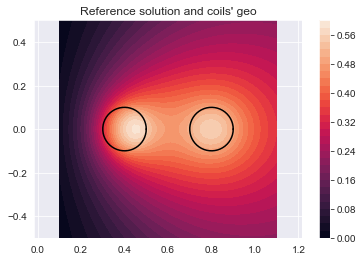

(0.05, 1.1500000000000001, -0.55, 0.55)

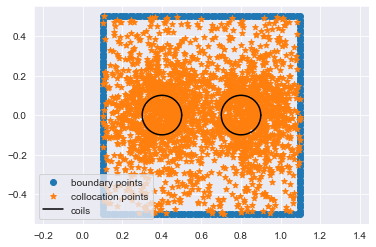

In [48]:
plt.figure();
plt.contourf(RR,ZZ,psi_grid,30);
plt.plot(coil1[:,0],coil1[:,1], c='k')
plt.plot(coil2[:,0],coil2[:,1], c='k')
plt.axis('equal')
plt.colorbar();
plt.title('Reference solution and coils\' geo');
plt.show();

fig = plt.figure()
plt.scatter(BCs_pts[:,0],BCs_pts[:,1], marker = 'o', label = 'boundary points')
plt.scatter(coll_pts[:,0],coll_pts[:,1],marker = '*', label = 'collocation points')
plt.plot(coil1[:,0],coil1[:,1], c='k', label = 'coils')
plt.plot(coil2[:,0],coil2[:,1], c='k')
plt.legend()
plt.axis('equal')


Define the input/output for training the the Deep Neural Network (DNN), i.e., `X_train` are the $(x,y)$ coordinates of the boundary points and `y_train` are the values of the function at these points. Moreover, we define also `X_r`, the vector of the $(x,y)$ coordinates of the collocation points.

In [49]:
# Set data type for TensorFlow
DTYPE='float64'
tf.keras.backend.set_floatx(DTYPE)

X_r    = tf.constant(coll_pts, dtype=DTYPE)  # -> collocation points
X_train = tf.constant(BCs_pts, dtype=DTYPE)   # -> boundary points
y_train = tf.constant(psi_BCs, dtype=DTYPE)  #-> values of function at boundary points
Source = tf.constant(Source_coll_points.ravel(),dtype=DTYPE)

fac_scale = np.sum(psi_BCs.reshape(-1,1))/np.sum(mu0*Source_coll_points*coll_pts[:,0].reshape(-1,1))/np.pi

n_input = 2
n_output = 1

print('No of collocation points = ', X_r.shape[0])
print('No of boundary points    = ', X_train.shape[0])

No of collocation points =  2472
No of boundary points    =  232


Define the architecture of the Neural Network.

In [50]:
# Define model architecture
class PINN_NeuralNet(tf.keras.Model):

    def __init__(self,
                 output_dim=1,
                 num_hidden_layers=8,
                 num_neurons_per_layer=20,
                 activation='tanh',
                 kernel_initializer='glorot_normal',
                 batch_normalization = False,
                 **kwargs):
        super().__init__(**kwargs)
        # define all layers in init
        # Layer of Block 1
        
        
        self.num_hidden_layers = num_hidden_layers
        self.output_dim = output_dim
        
        self.hidden = []
        for _ in range(num_hidden_layers):
            if batch_normalization: 
                self.hidden.append(tf.keras.layers.BatchNormalization())
            self.hidden.append(tf.keras.layers.Dense(num_neurons_per_layer,
                                                     activation=activation,
                                                     kernel_initializer=kernel_initializer))

        self.out = tf.keras.layers.Dense(output_dim)

        self.hist = []
        self.iter = 0

    def call(self, X, training=False):
        Z = X
        for i in range(len(self.hidden)):
            Z = self.hidden[i](Z)
        return self.out(Z)

Now define the solver architecture. Note that all the following methods can be merged in the previous `PINN_NeuralNet` class, rather than defining a solver.

In [51]:
class PINN_solver():
    def __init__(self, 
                 model, 
                 coll_pts = np.zeros((2,2))):
        self.model = model
        
        # (x,y) of the collocation points (where PDE is enforced)
        coll_pts = tf.constant(coll_pts)
        self.x = coll_pts[:,0]
        self.y = coll_pts[:,1]
        
        # for history and display callbacks
        self.hist = []
        self.hist_DNN = []
        self.hist_PDE = []
        self.iter = 0
        
    
    def display_callback(self, print_status_every_N_epochs = 50):
        ''' print loss on command window '''
        if self.iter % print_status_every_N_epochs == 0:
            print('epoch {:05d}: loss = {:10.8e}'.format(self.iter,self.train_loss))
            
    def display_during_training_callback(self):
        if self.epoch == 0:
            self.figure, self.ax = plt.subplots()
            plt.xlabel("epochs")
            plt.ylabel("cost")
            self.plot1 = self.ax.plot(range(self.epoch), self.hist)[0]
        else:
            self.plot1 = plt.plot(self.hist[self.epoch-1:self.epoch], '-')
            
            
    def history_callback(self):
        ''' stores loss history '''
        self.hist.append(self.train_loss)
        self.hist_DNN.append(self.train_loss_DNN)
        self.hist_PDE.append(self.train_loss_PDE)
        self.iter+=1
        
        
    def plot_history(self):
        ''' stores loss history '''
        plt.figure()
        plt.plot(self.hist, '-')
        plt.yscale('log')
        plt.title('Training history')
        plt.xlabel('epochs')
        plt.ylabel('loss')        
    
    
    def fun_r_MagnetoStatic_Axi_psi(self):
        """Residual of the PDE"""
        self = self.get_derivatives()
        jphi = Source
        res = self.u_xx + self.u_yy - self.u_x/self.x + mu0*jphi*self.x
        return res
    
    
    def get_derivatives(self):
        with tf.GradientTape() as g:
            x,y = self.x, self.y
            g.watch(x)
            with tf.GradientTape() as gg:
                gg.watch(x)
                u = self.model(tf.stack([x, y], axis=1))
            u_x = gg.gradient(u, x)  
        u_xx = g.gradient(u_x, x) 
        del g, gg
        
        with tf.GradientTape() as g:
            x,y = self.x, self.y
            g.watch(y)
            with tf.GradientTape(persistent=False) as gg:
                gg.watch(y)
                u = self.model(tf.stack([x, y], axis=1))
            u_y = gg.gradient(u, y)  
        u_yy = g.gradient(u_y, y) 
        del g, gg 
        
        self.u_x = u_x
        self.u_xx = u_xx
        self.u_y = u_y
        self.u_yy = u_yy
        return self 
    
        
    def loss_fun_PDE(self, y_ds, prediction,fac_scale_loss): #model, X_r, X_data, u_data):
        loss_PDE = tf.reduce_mean(tf.square(self.fun_r_MagnetoStatic_Axi_psi()))
        loss_DNN = tf.reduce_mean(tf.square(y_ds - prediction))
        
        loss_PDE = loss_PDE*fac_scale_loss
        loss = loss_DNN + loss_PDE
        return loss, loss_DNN, loss_PDE    
     
    
    ''' .fit method '''    
    def fit(self,
            X_train,
            y_train,
            fac_scale_loss = 1,
            optimizer=tf.keras.optimizers.Adam(),
            epochs=50,
            batch_size=32,
            verbose=True, 
            print_status_every_N_epochs = 50,
            display_during_training = False):
        ''' implement standard fit method via sub-classing'''


        @tf.function
        def train_step(x_ds,y_ds):
            with tf.GradientTape() as tape:
                predictions = self.model(x_ds, training=False)
                loss, loss_DNN, loss_PDE = self.loss_fun_PDE(y_ds, predictions,fac_scale_loss)
            gradients = tape.gradient(loss, self.model.trainable_variables)
            optimizer.apply_gradients(zip(gradients, self.model.trainable_variables))
                        
            train_loss     = tf.reduce_mean(loss)
            train_loss_DNN = tf.reduce_mean(loss_DNN)
            train_loss_PDE = tf.reduce_mean(loss_PDE)
            return train_loss, train_loss_DNN, train_loss_PDE
        
    
        train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train)).shuffle(X_train.shape[0]).batch(batch_size)
        for epoch in range(epochs):
            self.epoch = epoch
            for x_ds, y_ds in train_ds:
                loss, loss_DNN, loss_PDE = train_step(x_ds, y_ds)
               
                
            ###
            self.train_loss = loss.numpy()
            self.train_loss_DNN = loss_DNN.numpy()
            self.train_loss_PDE = loss_PDE.numpy()
            
            if verbose:
                self.display_callback(print_status_every_N_epochs = print_status_every_N_epochs)
                
            if display_during_training:
                self.display_during_training_callback()
                
            self.history_callback()

Now initialize the `PINN_NeuralNet` model and the `PINN_solver`.

In [52]:
sub_classing_model = PINN_NeuralNet(output_dim=n_output,
                                    num_hidden_layers=8,
                                    num_neurons_per_layer=20,
                                    activation='swish',
                                    kernel_initializer='he_normal',
                                    batch_normalization=False)
solver = PINN_solver(sub_classing_model, coll_pts)

Train the network. Here `fac_scale_loss` is chosen to scale the PDE equation, to avoid overshoots.

In [57]:
fac_scale_loss = .0001

N_iter = 2000
batch_size = 32;
epochs = 256
print('Starting training with epochs =', epochs)
t_start = datetime.now()
solver.fit(X_train,
           y_train,
           fac_scale_loss = fac_scale_loss,
           optimizer=tf.keras.optimizers.Adam(),
           epochs=epochs,
           batch_size=batch_size,
           print_status_every_N_epochs = 25)
t_end = datetime.now()
print(t_end - t_start)

Starting training with epochs = 256
epoch 00325: loss = 2.21711240e-03
epoch 00350: loss = 1.84084364e-03
epoch 00375: loss = 1.72973953e-03
epoch 00400: loss = 1.46526944e-03
epoch 00425: loss = 1.34963739e-03
epoch 00450: loss = 1.19892875e-03
epoch 00475: loss = 1.14881911e-03
epoch 00500: loss = 1.03714968e-03
epoch 00525: loss = 9.49276311e-04
epoch 00550: loss = 9.35565859e-04
0:02:13.450217


Plot training history.

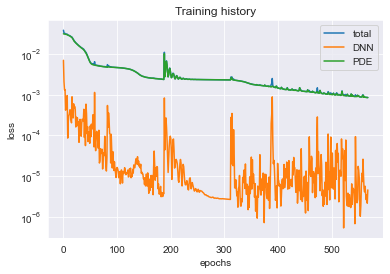

In [58]:
plt.figure()
plt.plot(solver.hist, '-', label = 'total')
plt.plot(solver.hist_DNN, '-', label = 'DNN')
plt.plot(solver.hist_PDE, '-', label = 'PDE')
plt.yscale('log')
plt.title('Training history')
plt.xlabel('epochs')
plt.ylabel('loss')       
plt.legend()

Test the model.

79/79 [==============================] - 0s 3ms/step


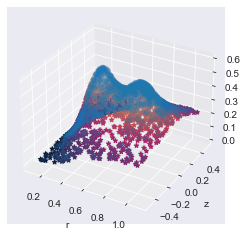

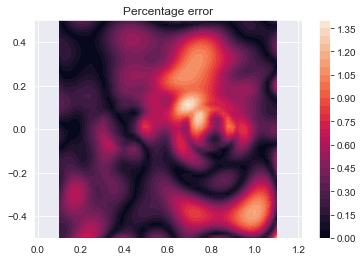

In [60]:
# test the model on the collocation points
X_test = X_r

sol_PINN = sub_classing_model.predict(X_test)
sol_ref = psi_coll_pts

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(X_test[:,0],X_test[:,1],sol_PINN,c = sol_PINN,marker = '*', alpha = 1)
ax.scatter(X_test[:, 0], X_test[:, 1], sol_ref, marker='o', alpha=.1)
ax.set_xlabel("r")
ax.set_ylabel("z")


# test the model on ta new set of points
X_grid, Y_grid = RR,ZZ
X_test = np.column_stack((X_grid.reshape(-1,1),Y_grid.reshape(-1,1)))

sol_PINN = sub_classing_model.predict(X_test)
sol_ref = psi_grid

plt.figure()
plt.contourf(X_grid, Y_grid, np.reshape(
    100*abs(sol_PINN - sol_ref.reshape(-1, 1)), X_grid.shape)/max(np.abs(sol_PINN)), 30)
plt.axis('equal')
plt.colorbar()
plt.title('Percentage error')
plt.show()